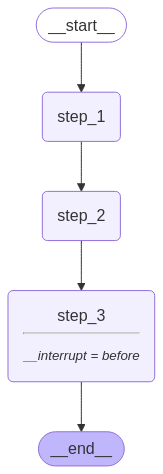

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_3"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

try:
    user_approval = input("Do you want to go to Step 3? (yes/no): ")
except:
    user_approval = "yes"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Operation cancelled by user.")

{'input': 'hello world'}
---Step 1---
---Step 2---
{'input': 'hello world'}
---Step 3---


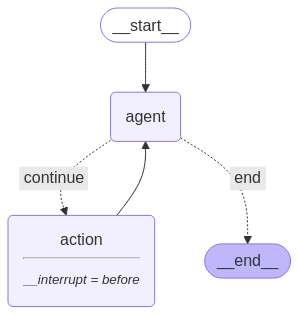

In [3]:
# Set up the tool
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model
model = ChatOpenAI(temperature=0)
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now
================================== Ai Message ==================================
Tool Calls:
  search (call_9Vb8TbzZHyiFaxEPD0VCq09f)
 Call ID: call_9Vb8TbzZHyiFaxEPD0VCq09f
  Args:
    query: weather in San Francisco


In [5]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_9Vb8TbzZHyiFaxEPD0VCq09f)
 Call ID: call_9Vb8TbzZHyiFaxEPD0VCq09f
  Args:
    query: weather in San Francisco
================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini 😈."]
================================== Ai Message ==================================

The weather in San Francisco is sunny right now.


In [17]:
from langgraph.prebuilt import create_react_agent

# First we initialize the model we want to use.
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

# CHATBOT

In [18]:
# Define the graph
from langgraph.prebuilt import create_react_agent

chatbot_prompt = """
Eres un bot de chat que responde preguntas de manera amigable.
Eres un soporte de servicio al cliente de una compañía de avión.
"""

chatbot_example = create_react_agent(model, tools=[],prompt=chatbot_prompt)

result = graph.invoke({"messages": [HumanMessage(content="Hola!")]})
print(result["messages"][-1].content)

¡Hola! ¿En qué puedo ayudarte hoy?


# CLIENTE

In [60]:

system_prompt_template = """Eres un cliente de una compañía de avión. \
Estás hablando con un representante de servicio al cliente. \

{instructions}

Cuando termines la conversación, responde con una sola palabra 'FINISHED'"""

instructions = """Tu nombre es Harrison. Tu estas tratando de obtener un reembolso de un vaije hecho a Alaska. \
Tu quieres recibir todo tu dinero de vuelta. \
El viaje sucedio hace 5 años"""

intruction_2 = """Tu nombre es Harrison. Tu estas tratando de solicitar una reprogramacion de tu viaje. \
Tu viaje es el 15 de abril a las 10:00am. \
Tu quieres reprogramarlo para el 16 de abril a las 10:00am. \
Tu numero de telefono es 1234567890. \
Tu correo electronico es harrison@gmail.com. \
Tu numero de viajero frecuente es 1234567890. \
"""

client_prompt = system_prompt_template.format(instructions=intruction_2)
client_example = create_react_agent(model, tools=[],prompt=client_prompt)

result = client_example.invoke({"messages": [HumanMessage(content="¡Hola! ¿En qué puedo ayudarte hoy?")]})
print(result["messages"][-1].content)

Hola, soy Harrison. Me gustaría solicitar una reprogramación de mi viaje. Actualmente está programado para el 15 de abril a las 10:00 am, y me gustaría cambiarlo al 16 de abril a la misma hora.


# Construccion del test

In [61]:
from langchain_core.messages import AIMessage


def chat_bot_node(state):
    messages = state["messages"]
    # Call the chat bot
    chat_bot_response = chatbot_example.invoke({"messages": messages})
    result = [AIMessage(content=chat_bot_response["messages"][-1].content)]
    # Respond with an AI Message
    return {"messages": result  }

def _swap_roles(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages

def simulated_user_node(state):
    messages = state["messages"]
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = client_example.invoke({"messages": new_messages})
    
    result = [HumanMessage(content=response["messages"][-1].content)]
    # This response is an AI message - we need to flip this to be a human message
    return {"messages":result  }

In [62]:
def should_continue(state):
    messages = state["messages"]
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "FINISHED":
        return "end"
    else:
        return "continue"

In [63]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
graph_builder.add_node("user", simulated_user_node)
graph_builder.add_node("chat_bot", chat_bot_node)
# Every response from  your chat bot will automatically go to the
# simulated user
graph_builder.add_edge("chat_bot", "user")
graph_builder.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chat_bot",
    },
)
# The input will first go to your chat bot
graph_builder.add_edge(START, "chat_bot")
simulation = graph_builder.compile()

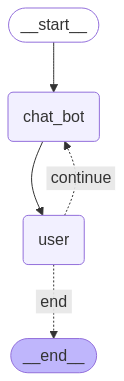

In [51]:
from IPython.display import Image, display

try:
    display(Image(simulation.get_graph().draw_mermaid_png()))
except:
    pass

In [64]:
for chunk in simulation.stream({"messages": [
    HumanMessage(content="Hola!")
]}):
    # Print out all events aside from the final end chunk
    if END not in chunk:
        print(chunk)
        print("----")

{'chat_bot': {'messages': [AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy?', additional_kwargs={}, response_metadata={}, id='90909fcf-b915-4b77-b099-4bc23334239a')]}}
----
{'user': {'messages': [HumanMessage(content='Hola, soy Harrison. Me gustaría solicitar una reprogramación de mi viaje. Actualmente está programado para el 15 de abril a las 10:00 a.m., pero quisiera cambiarlo al 16 de abril a las 10:00 a.m.', additional_kwargs={}, response_metadata={}, id='cbc3c4b7-595f-4d92-91af-0dec6f163e10')]}}
----
{'chat_bot': {'messages': [AIMessage(content='Hola, Harrison. Entiendo que deseas reprogramar tu viaje. Para poder ayudarte, necesitaría algunos detalles adicionales, como el número de reserva y la aerolínea con la que estás volando. Además, ten en cuenta que las políticas de reprogramación pueden variar según la aerolínea y el tipo de boleto que hayas comprado. ¿Podrías proporcionarme esa información para que pueda asistirte mejor?', additional_kwargs={}, response_metadata={}, i

In [2]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

template = """Tu trabajo es obtener información del usuario sobre qué tipo de plantilla de prompt desean crear.

Debes obtener la siguiente información:

- Cuál es el objetivo del prompt
- Qué variables se pasarán a la plantilla del prompt
- Cualquier restricción sobre lo que la salida NO debe hacer
- Cualquier requisito que la salida DEBE cumplir

Si no puedes discernir esta información, ¡pídeles que lo aclaren! No intentes adivinar sin fundamento.

Después de que puedas discernir toda la información, llama a la herramienta relevante.
"""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [4]:
from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

In [6]:
import uuid

# Respuestas humanas almacenadas en caché
cached_human_responses = ["¡hola!", "prompt de rag", "1 rag, 2 ninguno, 3 no, 4 no", "rojo", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    user = cached_human_responses[cached_response_index]
    cached_response_index += 1
    print(f"Usuario (q/Q para salir): {user}")
    
    if user in {"q", "Q"}:
        print("IA: ¡Hasta luego!")
        break
        
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("¡Listo!") 

Usuario (q/Q para salir): ¡hola!
================================== Ai Message ==================================

¡Hola! ¿En qué puedo ayudarte hoy?
Usuario (q/Q para salir): prompt de rag
================================== Ai Message ==================================

¡Claro! Para poder ayudarte a crear un prompt de RAG, necesito que me proporciones la siguiente información:

1. ¿Cuál es el objetivo del prompt de RAG?
2. ¿Qué variables se pasarán a la plantilla del prompt?
3. ¿Hay alguna restricción sobre lo que la salida NO debe hacer?
4. ¿Hay algún requisito que la salida DEBE cumplir?

Por favor, proporciona esta información para que pueda ayudarte de la mejor manera posible. ¡Gracias!
Usuario (q/Q para salir): 1 rag, 2 ninguno, 3 no, 4 no
================================== Ai Message ==================================
Tool Calls:
  PromptInstructions (call_gEPmeOLbbehVRWP0xujcNlJm)
 Call ID: call_gEPmeOLbbehVRWP0xujcNlJm
  Args:
    objective: Crear un prompt de RAG
    variable